In [4]:
from f_drosophila_infer import *
from f_train import *
from f_data_prep import *

In [5]:
def ER_quad_elastic_train_test(X, y, gene_comp=[], kf=10, a=0.1, r=0):
    quad = np.copy(X)
    kfold = KFold(n_splits=kf, shuffle=False, random_state=1)
    
    error_list=[]
    if len(gene_comp) == 0:
        for i in range(X.shape[1]-1):
            for j in range(i+1, X.shape[1]):
                quad = np.hstack((quad, (X[:,i]*X[:,j])[:,None]))
    else:
        for i in range(len(comp_ind)-1):
            for j in range(i+1, len(comp_ind)):
                quad = np.hstack((quad, (X[:,comp_ind[i]]*X[:,comp_ind[j]])[:,None]))
            
    for (tr_ind, te_ind) in (kfold.split(y)):
        X_tr, quad_tr, y_tr = X[tr_ind], quad[tr_ind], y[tr_ind]
        X_te, quad_te, y_te = X[te_ind], quad[te_ind], y[te_ind]
        
        if len(gene_comp) == 0 or y.shape[1] != len(gene_comp):
            y_actual = X_te + y_te
        elif y.shape[1] == len(gene_comp):
            y_actual = X_te[:, gene_comp] + y_te

        y_actual_sum_sq = np.sum(np.abs(y_actual)**2, axis=0)
        w, sigma, bias = ER_quad_elastic(quad_tr, y_tr, power=3, alpha_=a, ratio_=r)
        if len(gene_comp) == 0 or y.shape[1] != len(gene_comp):
            y_pred = X_te + odd_power(bias+quad_te.dot(w), 3) + sigma*npr.normal(size=(1,w.shape[1]))
        elif y.shape[1] == len(gene_comp):
            y_pred = X_te[:,gene_comp] + odd_power(bias+quad_te.dot(w), 3) + sigma*npr.normal(size=(1,w.shape[1]))
        error = (np.sum(np.abs(y_pred - y_actual)**2, axis=0)/y_actual_sum_sq)**(1/2)
        error_list.append(error)
    return np.mean(error_list, axis=0), np.std(error_list, axis=0)

In [6]:
data_all = np.loadtxt('../data_complete.txt')
data_all = data_all - np.median(data_all, axis=0)
all_bin = np.vsplit(data_all, 6)
all_init = np.vstack([all_bin[i] for i in range(5)])
all_diff = np.vstack([all_bin[i+1]-all_bin[i] for i in range(5)])

complete_all = ([int(x) - 1 for x in open('../indices_complete.txt','r').readline().split()])
comp_ind = list(map(int, list((np.array(complete_all)[::6]-3)/6)))

data_comp = np.copy(data_all[:, comp_ind])
comp_bin = np.vsplit(data_comp, 6)
comp_init = np.vstack([comp_bin[i] for i in range(5)])
comp_diff = np.vstack([comp_bin[i+1] - comp_bin[i] for i in range(5)])

In [7]:
all_init, all_diff = shuffle(all_init, all_diff)
comp_init, comp_diff = shuffle(comp_init, comp_diff)

In [29]:
import multiprocessing
from joblib import Parallel, delayed

from sklearn.model_selection import GridSearchCV, ParameterGrid

num_cores = multiprocessing.cpu_count()
grid = {'alpha': np.logspace(-1,3,5),\
            'l1_ratio' :[.1, .2, .3, .4, .5, .6, .7, .8, .9]}
grid_list=list(ParameterGrid(grid))

def test_parallel(i):
    alpha = grid_list[i]['alpha']
    ratio = grid_list[i]['l1_ratio']
    
    all_mean, all_std = ER_quad_elastic_train_test(all_init, all_diff,\
                                                   gene_comp=comp_ind, kf=10,\
                                                   a=alpha, r=ratio)

    all27_mean, all27_std = ER_quad_elastic_train_test(all_init, comp_diff,\
                                                       gene_comp=comp_ind, kf=10,\
                                                       a=alpha, r=ratio)

    comp_mean, comp_std = ER_quad_elastic_train_test(comp_init, comp_diff,\
                                                     gene_comp=[], kf=10,\
                                                     a=alpha, r=ratio)
    return alpha, ratio, all_mean, all_std, all27_mean, all27_std, comp_mean, comp_std

results = Parallel(n_jobs=num_cores, verbose=10)(delayed(test_parallel)(i) for i in range(len(grid_list)))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: 

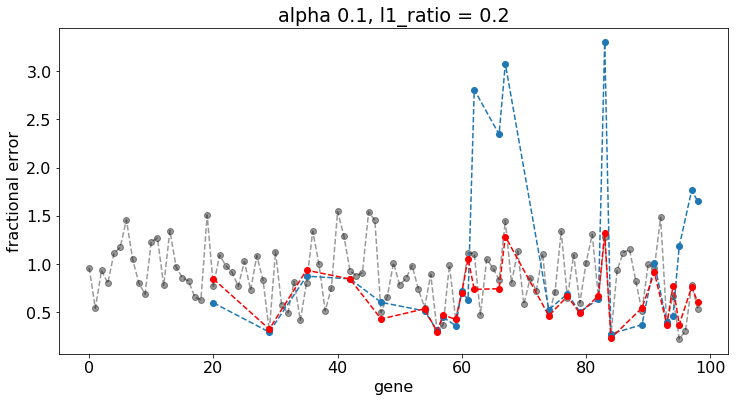

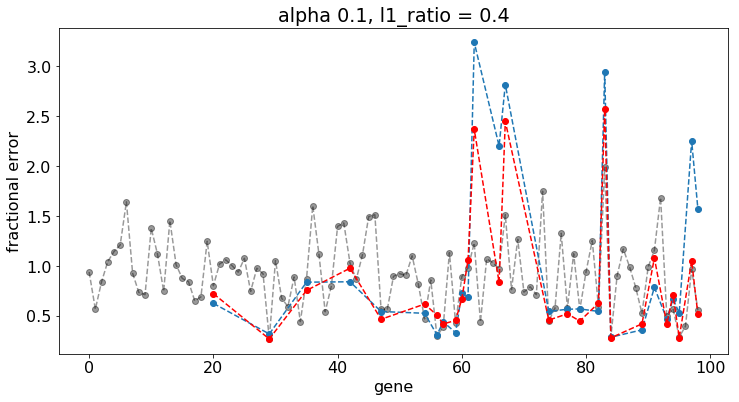

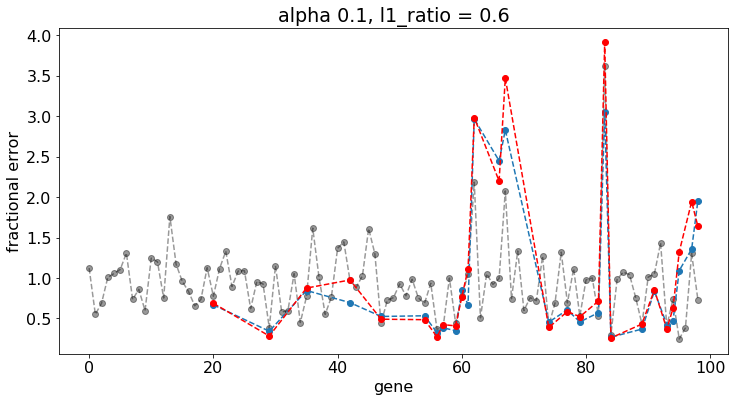

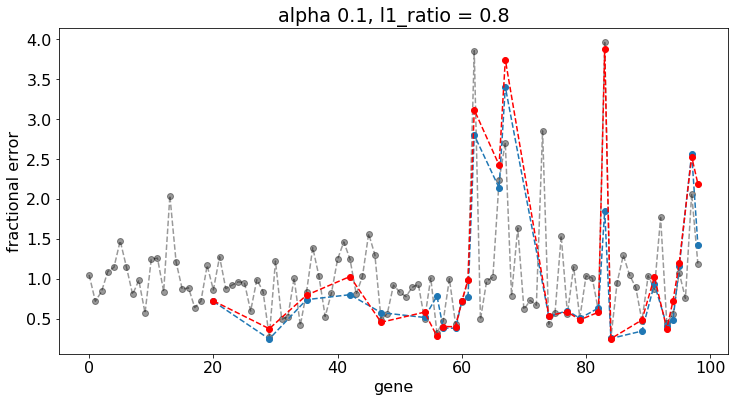

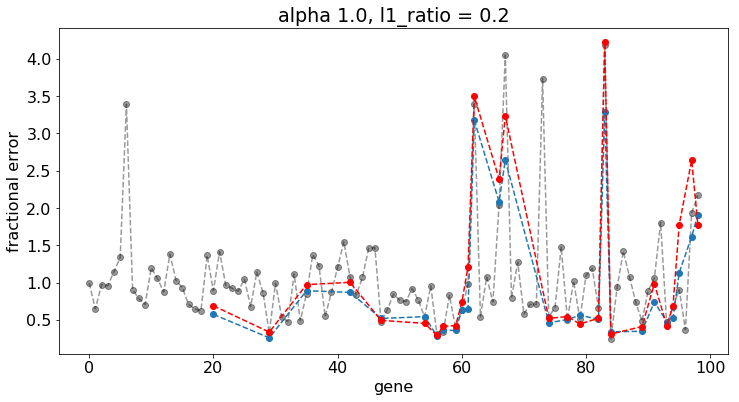

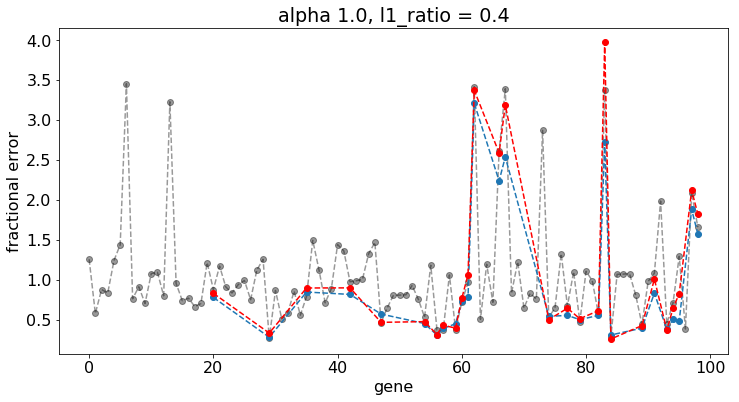

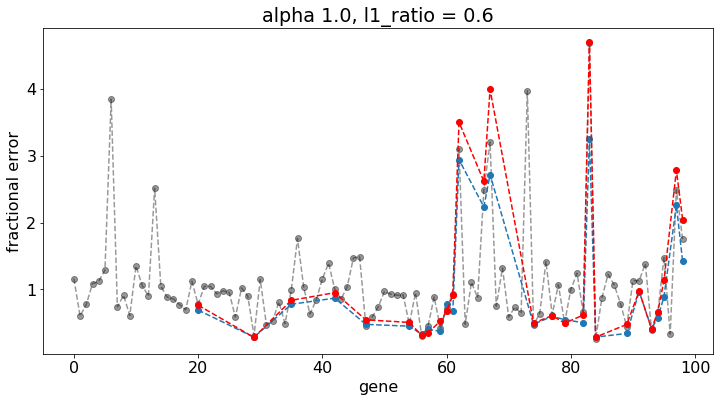

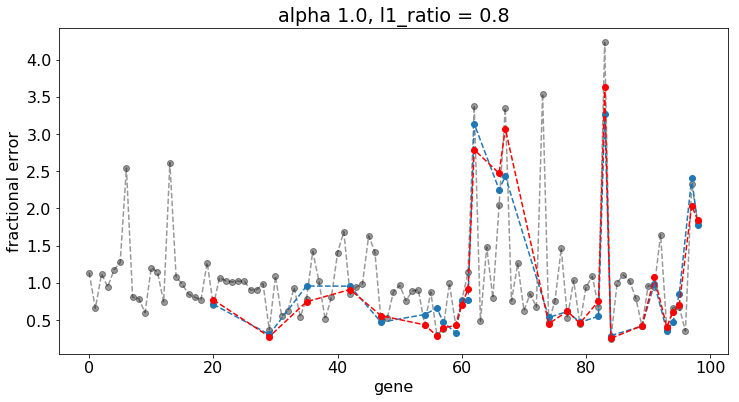

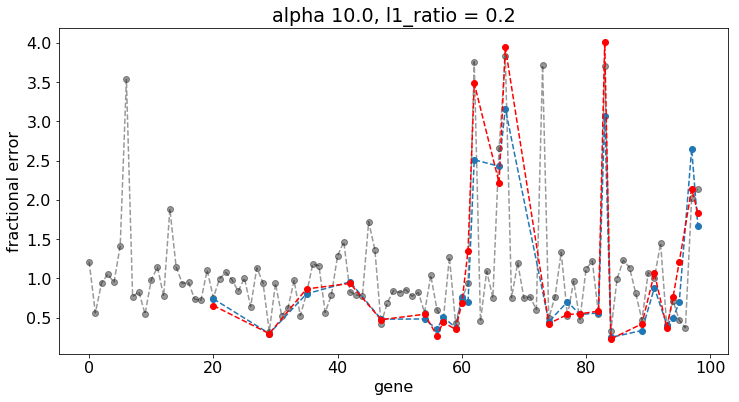

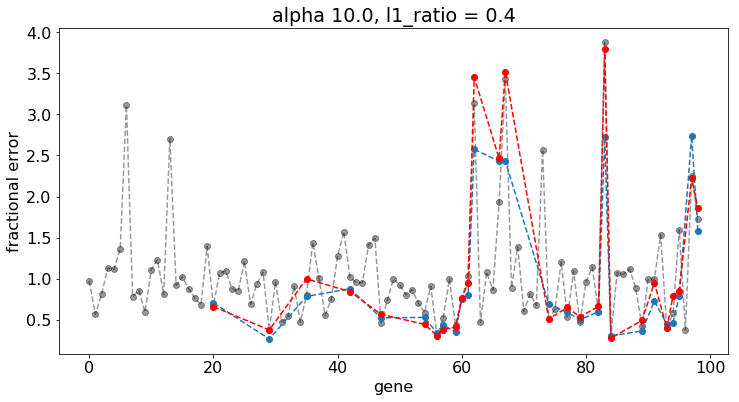

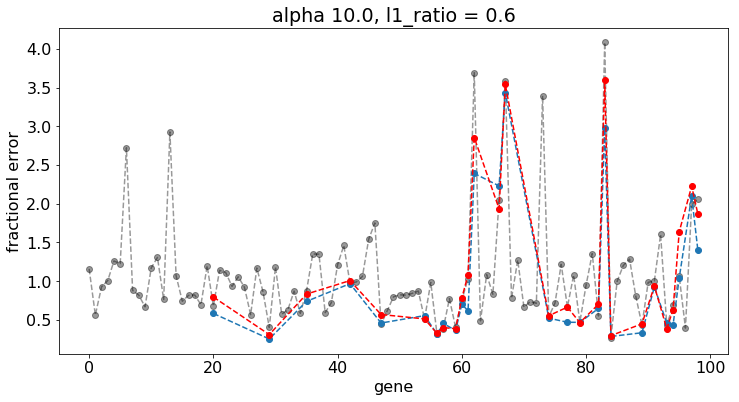

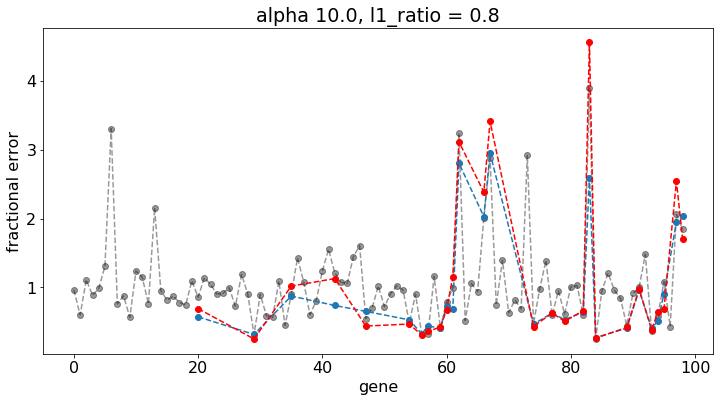

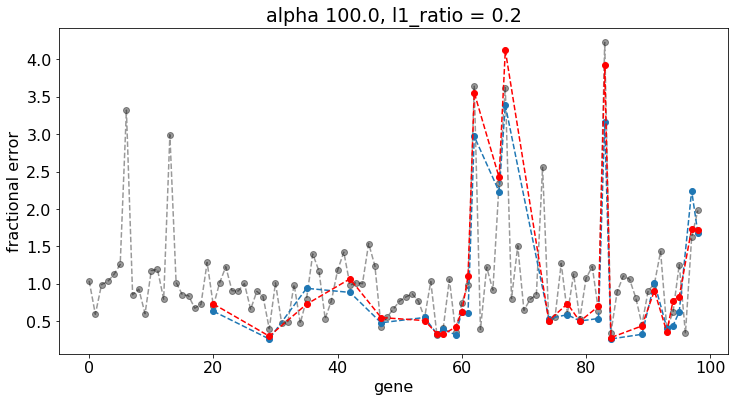

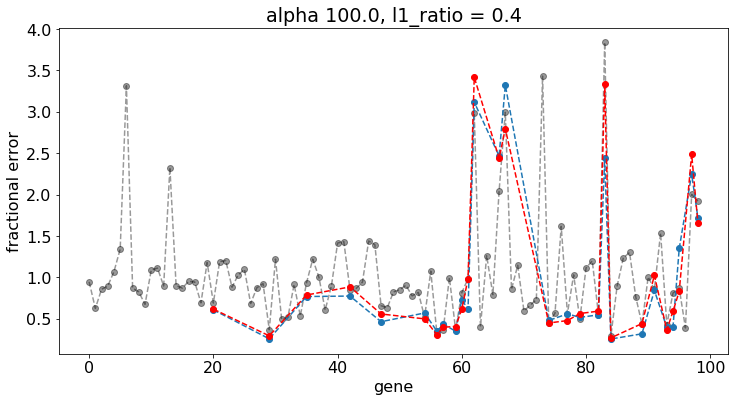

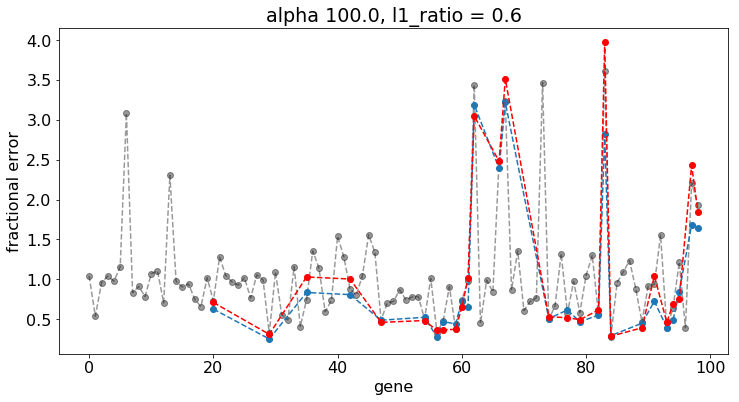

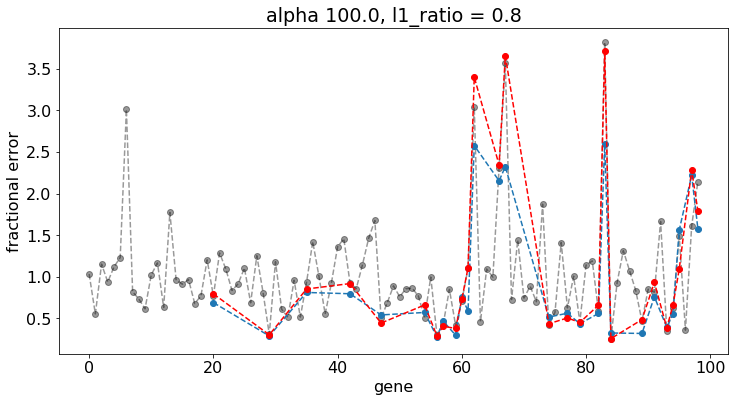

In [9]:
%matplotlib inline
for res in results:
    plt.figure(figsize=(12,6))
    plt.plot(range(len(res[2])), res[2], 'ko--', alpha=0.4)
    plt.plot(comp_ind, res[4], 'o--')
    plt.plot(comp_ind, res[6], 'ro--')
    plt.xlabel('gene')
    plt.ylabel('fractional error')
    plt.title('alpha %s, l1_ratio = %s' % (res[0], res[1]))
    plt.show()

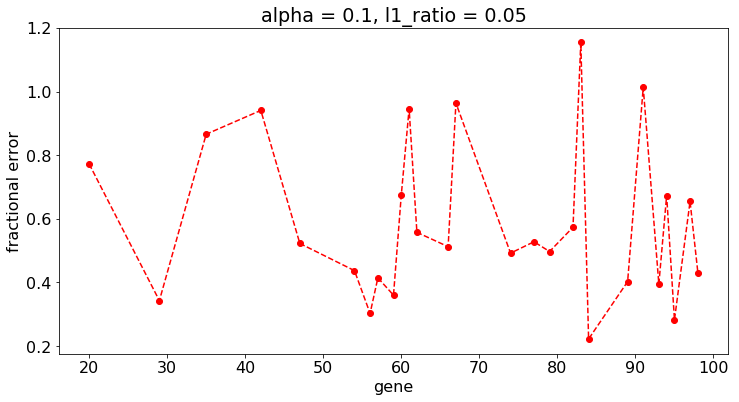

alpha = 0.1, l1_ratio = 0.05 
 0.522 0.59 +/- 0.245


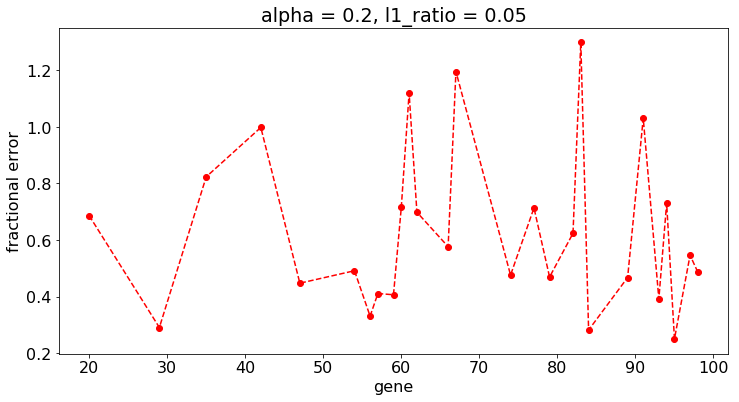

alpha = 0.2, l1_ratio = 0.05 
 0.546 0.628 +/- 0.283
Time: 1483.7241610500496


In [12]:
from sklearn.model_selection import GridSearchCV, ParameterGrid

grid = {'alpha': [0.1, 0.2],\
            'l1_ratio' :[0.05]}
grid_list=list(ParameterGrid(grid))

start = timeit.default_timer()
for i in range(len(grid_list)):
    alpha = grid_list[i]['alpha']
    ratio = grid_list[i]['l1_ratio']
    
#     all_mean, all_std = ER_quad_elastic_train_test(all_init, all_diff,\
#                                                    gene_comp=comp_ind, kf=10,\
#                                                    a=alpha, r=ratio)
#     all27_mean, all27_std = ER_quad_elastic_train_test(all_init, comp_diff,\
#                                                        gene_comp=comp_ind, kf=10,\
#                                                        a=alpha, r=ratio)
    comp_mean, comp_std = ER_quad_elastic_train_test(comp_init, comp_diff,\
                                                     gene_comp=[], kf=10,\
                                                     a=alpha, r=ratio)
    
    plt.figure(figsize=(12,6))
#     plt.plot(range(len(all_mean)), all_mean, 'ko--', alpha=0.4)
#     plt.plot(comp_ind, all27_mean, 'o--')
    plt.plot(comp_ind, comp_mean, 'ro--')
    plt.xlabel('gene')
    plt.ylabel('fractional error')
    plt.title('alpha = %s, l1_ratio = %s' \
              % (alpha, ratio))
    plt.show()
    
    print('alpha = %s, l1_ratio = %s' % (alpha, ratio),\
#           '\n', round(np.median(all_mean), 3), round(np.mean(all_mean), 3), '+/-', round(np.std(all_mean), 3),\
#           '\n', round(np.median(all_mean[comp_ind]), 3), round(np.mean(all_mean[comp_ind]), 3), '+/-', round(np.std(all_mean[comp_ind]), 3),\
#           '\n', round(np.median(all27_mean), 3), round(np.mean(all27_mean), 3), '+/-', round(np.std(all27_mean), 3),\
          '\n', round(np.median(comp_mean), 3), round(np.mean(comp_mean), 3), '+/-', round(np.std(comp_mean), 3))

end = timeit.default_timer()
print('Time: %s' % (end-start))

In [ ]:
from sklearn.model_selection import GridSearchCV, ParameterGrid

grid = {'alpha': np.logspace(-1,2,4),\
            'l1_ratio' :[.2, .4, .6, .8]}
grid_list=list(ParameterGrid(grid))

start = timeit.default_timer()
for i in range(len(grid_list)):
    alpha = grid_list[i]['alpha']
    ratio = grid_list[i]['l1_ratio']
    
    all_mean, all_std = ER_quad_elastic_train_test(all_init, all_diff,\
                                                   gene_comp=comp_ind, kf=10,\
                                                   a=alpha, r=ratio)
    all27_mean, all27_std = ER_quad_elastic_train_test(all_init, comp_diff,\
                                                       gene_comp=comp_ind, kf=10,\
                                                       a=alpha, r=ratio)
    comp_mean, comp_std = ER_quad_elastic_train_test(comp_init, comp_diff,\
                                                     gene_comp=[], kf=10,\
                                                     a=alpha, r=ratio)
    
    plt.figure(figsize=(12,6))
    plt.plot(range(len(all_mean)), all_mean, 'ko--', alpha=0.4)
    plt.plot(comp_ind, all27_mean, 'o--')
    plt.plot(comp_ind, comp_mean, 'ro--')
    plt.xlabel('gene')
    plt.ylabel('fractional error')
    plt.title('alpha = %s, l1_ratio = %s' \
              % (alpha, ratio))
    plt.show()
    
    print('alpha = %s, l1_ratio = %s' % (alpha, ratio),\
          '\n', round(np.median(all_mean), 3), round(np.mean(all_mean), 3), '+/-', round(np.std(all_mean), 3),\
          '\n', round(np.median(all_mean[comp_ind]), 3), round(np.mean(all_mean[comp_ind]), 3), '+/-', round(np.std(all_mean[comp_ind]), 3),\
          '\n', round(np.median(all27_mean), 3), round(np.mean(all27_mean), 3), '+/-', round(np.std(all27_mean), 3),\
          '\n', round(np.median(comp_mean), 3), round(np.mean(comp_mean), 3), '+/-', round(np.std(comp_mean), 3))

end = timeit.default_timer()
print('Time: %s' % (end-start))

In [8]:
(end-start)/60/60

8.11269011933253